In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Interpreting expected values (Fig. 6-3)

**Description**
* We enter a fair gamble (50-50% probs)
* If lucky we win `$10`.  Otherwise we lose `$10`
* $E(prize) = 0.5(10) + 0.5(-10) = 0$
* We will show that the expected value can be interpreted as the long-term average cumulative earnings

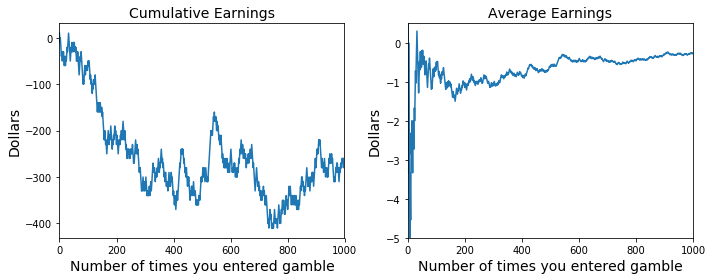

In [13]:
np.random.seed(1005)
# We will repeat the experiment N times: you can plug in different values
N = 1000
# Initialize array to store results and counters
total_earnings = np.zeros((N,2))
count_win = 0
count_los = 0
for i in range(N):
    # Draw from uniform distribution to simulate bernoulli trials
    draw = np.random.rand()
    if draw>=0.5:
        total_earnings[i,:] = [10,draw]
        count_win +=1
    else:
        total_earnings[i,:] = [-10,draw]
        count_los +=1

# Compute Cumulative and average earnings
total_earnings = pd.DataFrame(total_earnings ,columns = ['earn','prob'])
total_earnings['cumulative_earnings'] = total_earnings.earn.cumsum()
total_earnings['trials'] = np.arange(1,N+1)
total_earnings['avg_earnings'] = total_earnings.cumulative_earnings/total_earnings.trials
# ready to plot
fig, ax = plt.subplots(1,2, figsize=(10,4))
total_earnings.cumulative_earnings.plot(ax=ax[0])
ax[0].set_title('Cumulative Earnings', fontsize=14)
ax[1].set_title('Average Earnings', fontsize=14)
ax[0].set_ylabel('Dollars', fontsize=14)
ax[1].set_ylabel('Dollars', fontsize=14)
ax[0].set_xlabel('Number of times you entered gamble', fontsize=14)
ax[1].set_xlabel('Number of times you entered gamble', fontsize=14)
ax[1].axis([0,N,-5,0.5])
total_earnings.avg_earnings.plot(ax=ax[1])
plt.tight_layout()

# Evaluating different decision criteria:

* The proposed decision criterion is to pull the lever that maximizes the expected value or expected utility
* But why is this optimal?
* We are going to compare to two additional criteria:
    * **Ex-ante**: Maximizing expected value
    * **Ex-post**: first-best
    * **Maximum Value**: pull the lever with maximum value _independently_ of the probabilities

### Notes to understand code:

* We don't know if a customer will accept our offers or not
    * That's why we simulate these choices by drawing from uniform distributions
    * For instance: below we say that $\text{Prob(Accept A)} = 0.6$
    * We draw a uniform random variable $x \sim U(0,1)$ and customer will accept if $x<=0.6$.  This is how we simualate our customers choices
    
* Ex-ante:
    * Our choice is the lever (A,B) that maximizes the expected value
    * But our outcome depends on whether our choice and our customer's choice are aligned
    
* Ex-post:
    * Ex-post we can always make the best possible choice
    * We see if customer accepts A or B, and choose the best outcome for us
    
* Maximum Value:
    * We choose the lever with maximum CLV
    * But our earnings depend on the alignment of our choice and our customer's acceptance

In [14]:
def get_exante_earnings(accepts_a, accepts_b, exante_choice, clv_a, clv_b):
    '''
    Our earnings depend on customer's acceptance of each offer and Expected Utility
    1. If E(A)>E(B): we choose to offer alternative A
       If customer accepts A we make CLV_A otherwise we make 0
    2. If E(A)<E(B): we offer B
       If customer accepts B we make CLV_B otherwise 0
    '''
    earn_ea = 0
    if accepts_a == True and exante_choice=='a':
        earn_ea = clv_a
    elif accepts_b == True and exante_choice=='b':
        earn_ea = clv_b    
    return earn_ea


def get_expost_earnings(accepts_a, accepts_b, clv_a, clv_b):
    '''
    Ex-post is first-best: we choose as if there was no uncertainty
    1. If customer accepts A and not B -> offer A
    2. If customer accepts B and not A -> offer B
    3. If customer accepts both -> offer the best for us
    '''
    earn_ep = 0
    if accepts_a == True and accepts_b ==False :
        earn_ep = clv_a
    elif accepts_a == False and accepts_b ==True :
        earn_ep = clv_b
    elif accepts_a == True and accepts_b ==True :
        earn_ep = np.max(np.array([clv_a, clv_b]))
    return earn_ep

def get_maxvalue_earnings(accepts_a, accepts_b, clv_a, clv_b):
    '''
    Rule: if CLV_A>CLV_B -> offer A (otherwise B)
    Earnings: we only make corresponding CLV if it aggrees with acceptance
    '''
    earn_mv = 0
    if clv_a>=clv_b and accepts_a ==True:
        earn_mv = clv_a
    elif clv_a<=clv_b and accepts_b == True:
        earn_mv = clv_b
    return earn_mv



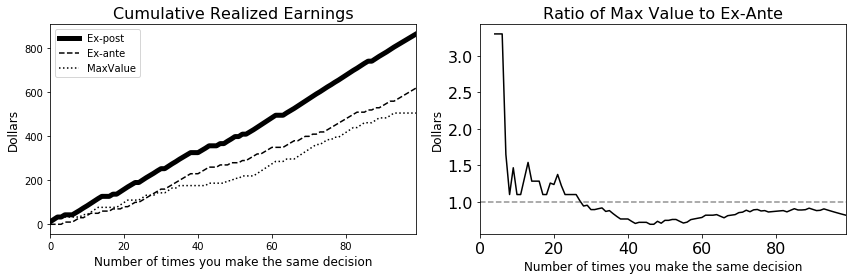

In [16]:
np.random.seed(7590)
# Customer lifetime values if accepts (otherwise 0)
clv_a = 10
clv_b = 11
# acceptance probability
prob_a = 0.6
prob_b = 0.5
# expected values and optimal choice under expected utility
evalue_a = prob_a*clv_a + (1-prob_a)*0
evalue_b = prob_b*clv_b + (1-prob_b)*0
if evalue_a> evalue_b:
    exante_choice = 'a'
else:
    exante_choice = 'b'
# simulate T choices: earnings initialized to 0
T = 100
total_earnings = pd.DataFrame(index=np.arange(T), columns=['exante','expost','max_prob','max_value'])
for t in range(T):
    # Simulate uncertain choices by our customers
    accepts_a = np.random.rand() <= prob_a
    accepts_b = np.random.rand() <= prob_b
    # Ex-ante Optimal:
    total_earnings.exante.loc[t] = get_exante_earnings(accepts_a, accepts_b, exante_choice, clv_a, clv_b)
    # Ex-post optimal:
    total_earnings.expost.loc[t] = get_expost_earnings(accepts_a, accepts_b, clv_a, clv_b)
    # Always choose max_value
    total_earnings.max_value.loc[t] = get_maxvalue_earnings(accepts_a, accepts_b, clv_a, clv_b)

# Plot
fig, ax = plt.subplots(1,2, figsize=(12,4))
total_earnings.expost.cumsum().plot(ax=ax[0],color='k', ls='-',lw=5, label='Ex-post')
total_earnings.exante.cumsum().plot(ax=ax[0],color='k', ls='--', label='Ex-ante')
ax[0].set_title('Cumulative Realized Earnings', fontsize=16)
total_earnings.max_value.cumsum().plot(ax=ax[0],color='k', ls='dotted', label='MaxValue')
df_relative_earnings = pd.DataFrame(total_earnings.max_value.cumsum()/total_earnings.exante.cumsum(), columns=['ratio'])
df_relative_earnings.ratio.plot(ax=ax[1],fontsize=16, legend=None, color='k')
ax[1].plot([0,100],[1,1], ls='--', alpha=0.5, color='0.15')
ax[1].set_title('Ratio of Max Value to Ex-Ante', fontsize=16)
ax[1].set_xlabel('Number of times you make the same decision', fontsize=12)
ax[0].set_xlabel('Number of times you make the same decision', fontsize=12)
ax[0].set_ylabel('Dollars',fontsize=12)
ax[1].set_ylabel('Dollars',fontsize=12)
ax[0].legend(loc=2)
plt.tight_layout()